Q3. Practice using pre-trained neural networks to extract domain-specific features for new tasks.

a. Read the pytorch tutorial to use a pre-trained “ConvNet as fixed feature extractor” from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and you can ignore “finetuning the ConvNet”. Test this code out to see if it runs properly in your environment after eliminating code blocks that you do not need. [1]

b. Write a function that outputs ResNet18 features for a given input image. Extract features for training images (in image_datasets['train']). You should get an Nx512 dimensional array. [1]

c. Compare RBF kernel SVM (do grid search on kernel width and regularization) and random forest (do grid search on max depth and number of trees). Test the final model on test data and show the results -- accuracy and F1 score. [1]

In [218]:
#Q3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/rajdipingale/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

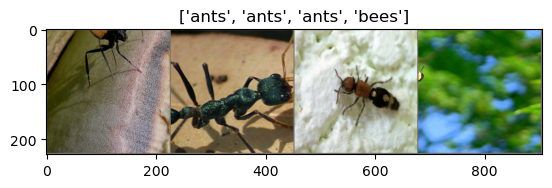

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [9]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6010 Acc: 0.6352
val Loss: 0.2304 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4055 Acc: 0.8279
val Loss: 0.2219 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4215 Acc: 0.8115
val Loss: 0.2200 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.7753 Acc: 0.6803
val Loss: 0.2068 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4379 Acc: 0.7869
val Loss: 0.2065 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4184 Acc: 0.8361
val Loss: 0.1945 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4008 Acc: 0.8238
val Loss: 0.3100 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3472 Acc: 0.8484
val Loss: 0.2088 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3532 Acc: 0.8443
val Loss: 0.1885 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4355 Acc: 0.8156
val Loss: 0.1947 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3156 Acc: 0.8730
val Loss: 0.2064 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3535 Acc: 0.8361
val Loss: 0.2011 Acc: 0.9412

Ep

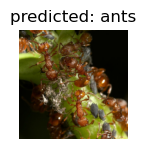

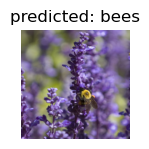

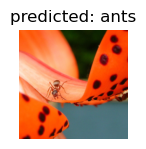

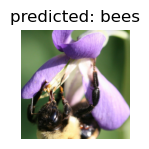

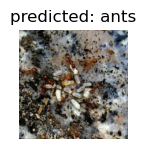

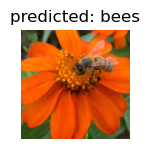

In [10]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [11]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

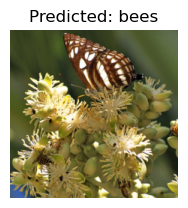

In [12]:
visualize_model_predictions(
    model_conv,
    img_path='/Users/rajdipingale/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

In [207]:
#B
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
from sklearn.svm import SVC
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [208]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
 }

data_dir = '/Users/rajdipingale/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                            shuffle=False)
              for x in ['train']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [209]:
#function for extracting features from train data
def Train_feature_extraction_resnet18():

  resnet18 = models.resnet18(weights= 'IMAGENET1K_V1')
  resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))
  resnet18.eval()


  features=[]

  for images, _ in dataloaders['train']:
      with torch.no_grad():
            outputs_f = resnet18(images)
            features.append(outputs_f.squeeze().numpy())

  features_train = torch.tensor(features)
  return features_train

In [210]:
#converting features into dataframe and visualising it
features = Train_feature_extraction_resnet18()
print(features.shape)
df_train = pd.DataFrame(features)
df_train.head()

torch.Size([244, 512])


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.350480,0.014958,0.218153,0.656708,1.129137,0.025134,2.973295,0.185228,0.201880,0.178118,...,0.139266,0.758280,0.550188,0.026733,0.253370,0.483833,0.144717,0.998106,0.583390,0.300270
1,0.258910,0.265302,0.221107,3.330970,0.512156,0.087647,2.021068,0.459697,0.544566,0.446942,...,1.229763,0.109797,0.343164,0.176867,1.441258,0.811165,0.011292,0.531399,0.331717,0.615032
2,0.534788,0.641364,0.549786,1.182938,1.881911,0.303982,1.920145,0.666271,1.681052,0.288397,...,1.956208,1.055903,1.040558,2.931372,1.464955,2.509034,0.610695,1.019047,0.168119,1.002216
3,0.027972,0.015875,0.536172,3.423236,0.251572,0.298574,1.765242,0.400756,0.478786,0.118172,...,0.076983,0.233015,0.778013,0.099217,4.327785,1.140359,0.121880,0.295151,0.074150,0.342781
4,0.083951,0.149015,0.485663,1.997248,2.600815,0.322126,1.643941,0.527613,1.159160,1.786698,...,1.165421,1.192232,0.060856,2.373960,2.736274,0.488410,0.537710,0.330909,0.069864,1.088088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0.322623,0.150997,0.309238,3.143031,1.332136,1.432505,3.440064,0.586547,0.243056,0.063823,...,0.665277,0.033060,0.792005,0.711936,6.407601,0.487537,0.297337,1.651697,0.688469,1.039477
240,0.541089,0.792301,0.294551,1.795182,0.231367,0.483693,0.676842,0.960029,0.086045,0.434870,...,0.129466,0.062575,0.243888,0.008812,3.496820,0.930833,0.054356,1.001533,0.690086,1.136490
241,0.297656,0.260500,0.618884,3.508458,0.002804,0.000000,0.063789,0.000000,0.151184,0.643321,...,0.117121,0.047544,0.000485,0.133262,3.269493,1.383664,0.134731,0.774768,0.442313,0.102518
242,0.660334,0.375480,1.007843,1.571252,0.257544,1.332802,0.790775,0.945610,0.480952,0.198499,...,1.449395,0.038381,3.915427,0.762031,0.508315,0.648362,1.185867,0.673946,2.200325,0.042385


In [ ]:
#C
# inspiration: https://www.kaggle.com/code/winnie19900705/feature-extraction-resnet50-svm

In [212]:
#Extracting lables of images from datasets and saving as a list

def image_labels(dir):
    image_labels = []  # Empty list to store image labels
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            for image_file in os.listdir(class_dir):
                if image_file.endswith('.jpg') or image_file.endswith('.jpeg'):  
                    image_path = os.path.join(class_dir, image_file)
                    image_labels.append((image_path, class_name))
    return image_labels

# for train data:

dir = '/Users/rajdipingale/hymenoptera_data/train'
image_labels = image_labels(dir)
print("Number of train images with labels:", len(image_labels))

# Extract labels from the list
labels = [label[1] for label in image_labels]

# Add image labels to the DataFrame
df_train['label'] = labels

# Display the DataFrame
df_train.head

# Seperate into x and y for classification
X_train=df_train.iloc[:,0:512]
y_train= df_train.iloc[:,[512]]

#Encoding classes into 0 and 1
label_encoder = LabelEncoder()
y_train['label'] = label_encoder.fit_transform(y_train['label'])
print(y_train)

Number of train images with labels: 244
     label
0        1
1        1
2        1
3        1
4        1
..     ...
239      0
240      0
241      0
242      0
243      0

[244 rows x 1 columns]


/var/folders/jw/b828mxp17cg561jtj9ps_vr80000gn/T/ipykernel_95840/2007594453.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['label'] = label_encoder.fit_transform(y_train['label'])


In [213]:
#Validation data
data_transforms = {
    'val': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
 }

data_dir = '/Users/rajdipingale/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                            shuffle=False)
              for x in ['val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#function for extracting features from train data
def Val_feature_extraction_resnet18_val():

  resnet18 = models.resnet18(weights= 'IMAGENET1K_V1')
  resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))
  resnet18.eval()


  features=[]

  for images, _ in dataloaders['val']:
      with torch.no_grad():
            outputs_f = resnet18(images)
            features.append(outputs_f.squeeze().numpy())

  features_val = torch.tensor(features)
  return features_val
#converting features into dataframe and visualising it
features_val = feature_extraction_resnet18_val()
df_val = pd.DataFrame(features_val)
df_val.head(244)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.033272,0.002116,0.000000,1.166354,0.000000,0.000000,0.126775,0.380978,0.427342,0.061070,...,0.824117,0.112380,0.078756,0.468444,1.428530,0.169974,0.073215,0.581298,0.000000,0.015922
1,0.577112,1.662660,1.564238,2.331862,4.101635,0.019582,1.476202,1.387266,0.452959,0.106380,...,0.408243,0.163490,0.464716,0.466986,2.346056,1.662926,0.634648,1.023235,0.514936,0.191013
2,0.843394,0.398488,0.567574,1.689256,0.363232,0.750735,0.127764,1.096489,2.199647,0.019834,...,0.084869,1.153847,2.093449,0.907617,0.698234,0.484215,0.127557,0.532396,0.115664,1.196082
3,0.858208,0.037760,0.175276,3.357718,1.323702,0.505120,2.243701,0.588623,0.276590,1.049008,...,1.004452,0.000000,0.482415,0.039603,0.534758,2.135645,0.163420,2.467358,0.153985,1.192938
4,0.682224,0.430491,2.142173,0.211835,1.129497,0.581529,3.635407,0.474383,0.827486,0.682841,...,1.477078,0.011930,0.080750,0.189278,1.873994,0.201964,0.000000,0.013087,0.028592,0.854477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,1.053064,0.118711,0.812601,2.380635,0.513437,0.033973,1.859426,0.054979,0.788224,0.439871,...,1.358596,0.158058,0.519573,0.811168,2.557925,0.614704,0.501304,0.445496,0.058981,0.614836
149,0.124900,0.009635,0.006731,2.859663,0.758008,0.016583,1.581924,1.532713,0.590388,0.634099,...,0.814413,0.326841,0.245957,0.277803,4.890924,0.673633,0.081420,0.339951,0.345761,0.038110
150,1.037142,0.733230,0.525244,2.720323,1.446603,0.319608,1.591394,0.597017,0.846178,0.423695,...,1.185353,0.313976,0.629899,0.267406,2.756076,1.838431,0.555422,0.412096,0.538626,0.121486
151,0.232911,0.825950,0.668204,2.599491,1.233851,1.849657,1.385517,0.751873,0.148472,0.668882,...,0.868605,0.561268,2.408441,0.175381,2.963458,1.030192,0.921918,1.124151,0.564536,2.590160


In [214]:
dir_val = '/Users/rajdipingale/hymenoptera_data/val'
image_labelsv = get_image_labels(dir_val)
print("Number of validation images with labels:", len(image_labelsv))

# Extract image  labels from the list
labelsv = [label[1] for label in image_labelsv]

# Add image  labels to the DataFrame
df_val['label'] = labelsv

# Seperate into x and y for classification
X_val=df_val.iloc[:,0:512]
y_val= df_val.iloc[:,[512]]

#Encoding classes into 0 and 1
y_val['label'] = label_encoder.fit_transform(y_val['label'])
print(y_val)

Number of validation images with labels: 153
     label
0        1
1        1
2        1
3        1
4        1
..     ...
148      0
149      0
150      0
151      0
152      0

[153 rows x 1 columns]


/var/folders/jw/b828mxp17cg561jtj9ps_vr80000gn/T/ipykernel_95840/243841911.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val['label'] = label_encoder.fit_transform(y_val['label'])


In [203]:
#classification by Support vector machibe classifiers
y_train= np.ravel(y_train)
y_val= np.ravel(y_val)

#parameters for grid search
parameters = {
    'C': [0.1, 0.5,1, 10, 50],          # Regularization parameter
    'gamma': [0.1, 0.5,1, 10, 50],      # width of guassian
}
svc = SVC(kernel='rbf')
grid_search = GridSearchCV(estimator=svc, param_grid=parameters, cv=4, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Parameters:", best_params)
y_pred = best_estimator.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
f1 =f1_score(y_val, y_pred)
print("F1-score on test data is :", f1)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 0.1, 'gamma': 0.1}
Accuracy: 0.45751633986928103
F1-score on test data is : 0.0


In [217]:
#classification by Random forest  classifiers
y_train= np.ravel(y_train)
y_val= np.ravel(y_val)
# Define the parameter for grid search
param_grid = {
    'n_estimators': [10, 50, 100, 150,200],  # Number of trees in the forest
    'max_depth': [2,5, 10, 20,50]       # Maximum depth of the trees
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with the classifier
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_
print("Optimal Parameters:", best_params)

# Make predictions on the test data
y_pred = best_rf_classifier.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)

# Calculate F1 score
f1 = f1_score(y_val, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Optimal Parameters: {'max_depth': 2, 'n_estimators': 150}
Accuracy: 0.8496732026143791
F1 Score: 0.8516129032258064


Q4. Deploy one model from part 1 on a local webserver with a web frontend (e.g. using streamlit). Add some GUI elements, such as sliders for acidity, citrus etc.

In [ ]:
#streamlit code


#Importing all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
import streamlit as st

st.title("Wine quality Prediction")
st.subheader('Click on following checkboxes to see how aur model was trained')
#Reading data
white_fp=('/Users/rajdipingale/Documents/sample/white.xlsx')
white = pd.read_excel(white_fp,engine='openpyxl')
red_fp=('/Users/rajdipingale/Documents/sample/red.xlsx')
Red = pd.read_excel(red_fp,engine='openpyxl')

if st.checkbox('show  wine quality data'):
    st.subheader('white wine data')
    st.write(white)
    st.subheader('red wine data')
    st.write(Red)


st.set_option('deprecation.showPyplotGlobalUse', False)

if st.checkbox('Distribution of  wine data'):
    st.subheader('Distribution of white wine data coloumns')
    white.hist(figsize=(15, 10))  
    plt.tight_layout()  
    st.pyplot()
    st.subheader('Distribution of red wine data coloumns')
    Red.hist(figsize=(15, 10))  
    plt.tight_layout()  
    st.pyplot()

#Visualising  wine data each coloumn wise

yw= white['quality']                                 #last column is quality=y
Xw= white.drop("quality",axis=1)
yr= Red['quality']                                   #last column is quality=y
Xr= Red.drop("quality",axis=1)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)
Xr_train, Xr_val, yr_train, yr_val = train_test_split(Xr_train, yr_train, test_size=0.25, random_state=42)

# Split the data into train  validation and test samples
#for white wine data
Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw, yw, test_size=0.15, random_state=42)
Xw_train, Xw_val, yw_train, yw_val = train_test_split(Xw_train, yw_train, test_size=0.20, random_state=42)




#for white wine data
# For cross validating, let alpha are number of trees in set
alpha = [50,100,250,500,1000,2000]
cv_MSE=[]

                                                                          # creating empty list for MSE
#loop for cross validation for different values of number of trees
for i in alpha:
    rfw=RandomForestRegressor(n_estimators=i,random_state=42,n_jobs=-1)               #Fitting moadel on training data
    rfw.fit(Xw_train,yw_train)
    predict_yw = rfw.predict(Xw_val)
    cv_MSE.append(mean_squared_error(yw_val, predict_yw))                              #prediction on validaton data


#optimal no. trees with minimum CV error
best_alpha = np.argmin(cv_MSE)


if st.checkbox('Show model performance for white wine'):

#plot CV error vs no. of trees
    fig, ax = plt.subplots()
    ax.plot(alpha, cv_MSE,c='g')
    for i, txt in enumerate(np.round(cv_MSE,3)):
        ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_MSE[i]))
    plt.grid()
    plt.title("Cross Validation Error for white wine")
    plt.xlabel("No. of trees")
    plt.ylabel("MSE")
    st.pyplot(plt.gcf())

#fit final model on traing data with optimal hyperparameter
rfw=RandomForestRegressor(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
rfw.fit(Xw_train,yw_train)

if st.checkbox('Loss for train test and validation data for white wine'):
#print final MSE for train, validate and train
    predict_y = rfw.predict(Xw_train)
    st.write('For No. of trees = ', alpha[best_alpha], "The train MSE is:",mean_squared_error(yw_train, predict_y))
    predict_y = rfw.predict(Xw_val)
    st.write('For No. of trees = ', alpha[best_alpha], "The cross validation MSE is:",mean_squared_error(yw_val, predict_y))
    predict_y = rfw.predict(Xw_test)
    st.write('For No. of trees = ', alpha[best_alpha], "The test MSE is:",mean_squared_error(yw_test, predict_y))
    r2_test = r2_score(yw_test, predict_y)
    st.write('R^2 score on test data is:', r2_test)


#for red wine data
# For cross validating, let alpha are number of trees in set
alpha = [50,100,250,500,1000,2000]
cvr_MSE=[]

                                                                          # creating empty list for MSE
#loop for cross validation for different values of number of trees
for i in alpha:
    rfr=RandomForestRegressor(n_estimators=i,random_state=42,n_jobs=-1)               #Fitting moadel on training data
    rfr.fit(Xr_train,yr_train)
    predict_y = rfr.predict(Xr_val)
    cvr_MSE.append(mean_squared_error(yr_val, predict_y))                              #prediction on validaton data


#print all values of MSE for different values of number of trees
for i in range(len(cvr_MSE)):
    print ('MSE for no. of tree = ',alpha[i],'is',cvr_MSE[i])

#optimal no. trees with minimum CV error
best_alpha = np.argmin(cvr_MSE)


if st.checkbox('Show model performance for red wine'):

#plot CV error vs no. of trees
    fig, ax = plt.subplots()
    ax.plot(alpha, cvr_MSE,c='g')
    for i, txt in enumerate(np.round(cvr_MSE,3)):
         ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cvr_MSE[i]))
    plt.grid()
    plt.title("Cross Validation Error  for Red wine")
    plt.xlabel("No. of trees")
    plt.ylabel("MSE")
    st.pyplot(plt.gcf())

#fit final model on traing data with optimal hyperparameter
rfr=RandomForestRegressor(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
rfr.fit(Xr_train,yr_train)

if st.checkbox('Loss for train test and validation data for red wine'):
#print final MSE for train, validate and train
    predict_y = rfr.predict(Xr_train)
    st.write('For No. of trees = ', alpha[best_alpha], "The train MSE is:",mean_squared_error(yr_train, predict_y))
    predict_y = rfr.predict(Xr_val)
    st.write('For No. of trees = ', alpha[best_alpha], "The cross validation MSE is:",mean_squared_error(yr_val, predict_y))
    predict_y = rfr.predict(Xr_test)
    st.write('For No. of trees = ', alpha[best_alpha], "The test MSE is:",mean_squared_error(yr_test, predict_y))
    r2_test = r2_score(yr_test, predict_y)
    st.write('R^2 score on test data is:', r2_test)

st.subheader('Please use slider to provide faetures of wine')

#testing on new values
fixed_acidity = st.slider('Select a value for fixed acidity',0,16, 7)
volatile_acidity = st.slider('Select a value for volatile acidity',0.0,1.0, value= 0.5,step= 0.1)
citric_acid=st.slider('Select a value for citric_acid',0.0,2.0, value= 0.5, step= 0.1)
residual_sugar=st.slider('Select a value for residual sugar',0,60, 20)
chlorides=st.slider('Select a value for chlorides',0.0,1.0,value= 0.5, step= 0.1)
free_sulfur_dioxide=st.slider('Select a value for free sulfur dioxide',0,300, 200)
total_sulfur_dioxide=st.slider('Select a value for total sulfur dioxide',0,400, 250)
density=st.slider('Select a value for density',0.0,1.0,value= 0.5, step= 0.1)
pH=st.slider('Select a value for pH',0.0,4.0,value=1.0,step= 0.1)
sulphates=st.slider('Select a value for sulphates',0.0,1.0, value= 0.5, step= 0.1)
alcohol=st.slider('Select a value for alcohol',0,15, 8)

st.subheader('Predicted wine quality is:')

Xnew = [fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol]
Xnew= np.array(Xnew).reshape(1, -1)
predict_yw = rfw.predict(Xnew)

predict_yr = rfr.predict(Xnew)

st.write('Predicted value of White wine quality is:', predict_yw)

st.write('Predicted value of red wine quality is:', predict_yr)
